What is left to make it working: 
* 3D scan hat for hat.obj
* Print green fabric and put it on the hat
* Fly drone, capture footage of person wearing green hat
* Pre-process: run segment_green_hat to generate masks, annotate person_bbox and drone metadata into annotations.json
* Calibrate altitude_to_scale in annotations metadata
* Measure UV unwrapped hat, set mesh_unit_to_inches in CONFIG
* Get printer specs from FabLab, set DPI and gamut values in CONFIG
* Create printr Gamut.numpy
* Add more diverse models to blackbox: RT-DETR, YOLO-NAS, or a Faster R-
* Grid Search Tier 1: lambda_tv/lambda_nps/lambda_info. Tier 2: stage2_lr, local_latent_size, cutout_ratio, shakedrop_prob. score = mean_asr  (subject to: final_nps < threshold AND final_tv < threshold)

# CloakHat Patch Generation Pipeline

## 1: Conda Setup

* Conda is the main env manager, pip is for Python packages
* PyTorch is the main AI/ML library
* NVIDIA CUDA is for GPU acceleration
* PyTorch3D is for rendering the hat
* ipykernel allows JupyterLab to use the Conda env
* Ultralytics has YOLO models
* opencv-python-headless is for image processing
* matplotlib is for plots
* tqdm is for progress bars
* NumPy is for data manipulation

### Option 1:

Activate <br>
`conda env create -f environment.yaml` <br>
`conda activate cloakhat` <br>

Apply the kernel <br>
`python -m ipykernel install --user --name cloakhat --display-name "Python (cloakhat)"`

Deactivate <br>
`conda deactivate` <br>
`conda env remove -n cloakhat` <br>

### Option 2: 

Set up the environment

`conda create -n cloakhat python=3.10 -y` <br>
`conda activate cloakhat`

PyTorch with CUDA. Also ipykernel. <br>
`conda install pytorch ipykernel pytorch-cuda=11.8 -c pytorch -c nvidia -y`<br>

PyTorch3D for differentiable rendering <br>
`conda install -c pytorch3d pytorch3d -y`

Detection models <br>
`pip install ultralytics`

Other stuff <br>
`pip install opencv-python-headless matplotlib tqdm numpy`

Apply the kernel <br>
`python -m ipykernel install --user --name cloakhat --display-name "Python (cloakhat)"`

Deactivate <br>
`conda deactivate` <br>
`conda env remove -n cloakhat` <br>

### Option 3: 

Run the bash <br>
`bash LabSetup.sh`

Activate the kernel <br>
`conda activate cloakhat` <br>

Deactivate <br>
`conda deactivate` <br>
`conda env remove -n cloakhat` <br>

## 2: Python Setup

Get the libraries we need

In [1]:
#Deep learning stuff
import torch
import torch.nn as nn
import torch.nn.functional as F

#Data manipulation
import numpy as np

#Image processing
import cv2

#Plotting
import matplotlib.pyplot as plt

#Working with the file system
from pathlib import Path

#Progress bars
from tqdm import tqdm

#Better logging than print statements
import logging

#JSON utilities
import json

#PyTorch3d utilities
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (look_at_view_transform, FoVPerspectiveCameras, RasterizationSettings, MeshRasterizer, SoftPhongShader, TexturesUV, PointLights)

#Gets YOLO models
from ultralytics import YOLO

#Logging with timestamps
logging.basicConfig(level=logging.INFO, format='%(asctime)s | %(message)s')
logger = logging.getLogger(__name__)

#Check what device is being used (especially if we want GPU) and log it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Device: {device}")

2026-02-15 21:53:18,266 | Device: cuda


## 3: Config

Control variables

In [2]:
CONFIG = {
    'dataset_dir': './data/drone_footage', #Drone footage/image samples
    'mesh_path': './assets/Rough_Hat.obj', #Hat mesh
    'output_dir': './outputs', #Where out outputs will go (textures, evaluations, stuff like that)
    
    #Generator
    'latent_channels': 128, #Channels
    'latent_size': 9, #Spatial size of latent input
    #(so the latent is 128x9x9)
    'texture_size': 288, #Output texture size from generator
    #(so the latent becomes a texture that is 3x288x288)
    
    #Viewpoint sampling
    'scale_jitter': 0.1, #Fraction of scale variation
    'camera_pitch_jitter': 5.0, #Alias for elevation jitter (degrees)
    'heading_jitter': 10.0, #Alias for azimuth jitter (degrees)

    'num_workers': 8, #for DataLoader
    'det_conf_floor': 0.001, #Minimum confidence for detector loss
    
    #Training Stage 1
    'stage1_epochs': 100, #100 epochs
    'stage1_batch_size': 8, #8 batch minibatch gradient descent
    'stage1_lr': 2e-4, #learning rate
    
    #Training Stage 2  
    'stage2_batch_size': 8,
    'stage2_iterations': 2000, #Now we optimize the single tensor
    'stage2_lr': 0.01, #Bigger learning rate
    'local_latent_size': 18, #Size of optimizable latent pattern. Bigger than 9x9 (input), so tile seamlessly
    
    #Loss weights
    'lambda_tv': .1, #Total variation - makes the textures smoother/less noisy/able to be printed
    'lambda_nps': 0.01, #Non-printability score - penalize colors that can't print well
    'lambda_info': 0.1, #Mutual information (Stage 1 only) - ensures latent is correlated to the texture
    
    #T-SEA Stuff
    'cutout_prob': 0.9, #90% of the time, 
    'cutout_ratio': 0.4, #cut off 40% of the hat
    'shakedrop_prob': 0.5, #50% of the time, mess with the model (for self-ensemble)
    
    #Rendering
    'render_size': 256, #Output 256x256 images
    'image_size': 1920, #Standardized input image size for all frames
    'detector_input_size': 640,
    
    #Printer specifications (GET FROM FABLAB)
    'printer': {
        'dpi': 300,
        'mesh_unit_to_inches': None, #CALIBRATE: how many inches = 1 unit in the .obj file. None to auto-estimate.
        'seam_allowance_inches': 0.25, #Extra border for cutting
        'max_saturation': 0.85,
        'max_brightness': 0.95,
        'min_brightness': 0.08,
        'nps_threshold': 0.7, #Saturation * brightness threshold (penalize when saturation × brightness > 0.7)
        'gamut_samples_path': './assets/printer_gamut.npy',
    },
    
    #Attack config (white, gray, black)
    'attack_mode': 'white',
}

#Make sure the folder exists
Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)

## 4: Dataset Preparation

Prepare the dataset

In [3]:
#Dataset will look like
"""
dataset_dir/
        frames/
            frame_0001.png
            frame_0002.png
            ...
        masks/
            frame_0001_mask.png  (binary mask of green hat region)
            ...
        annotations.json  (person bounding boxes, metadata)

Annotations.json:
{
    "frames": [
        {
            "frame_id": "frame_0001",
            "image_path": "frames/frame_0001.png",
            "mask_path": "masks/frame_0001_mask.png",
            "person_bbox": [x1, y1, x2, y2],
            "drone": {
                "camera_pitch": 82.5,
                "heading": 45.0,
                "altitude_meters": 15.0
            }
        },
        ...
    ],
    "metadata": {
        "altitude_to_scale": {
            "min_altitude": 5.0,
            "max_altitude": 50.0,
            "min_scale": 0.3,
            "max_scale": 1.2
        }
    }
}
"""

#Dataset of the drone images
class DroneDataset(torch.utils.data.Dataset):

    #Loads annotations
    def __init__(self, dataset_dir):
        self.dataset_dir = Path(dataset_dir)
        #Makes sure placeholder exists
        if not self.dataset_dir.exists():
            raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")
        #Load annotations
        annotations_path = self.dataset_dir / 'annotations.json'
        if not annotations_path.exists():
            raise FileNotFoundError(f"Missing annotations.json in {dataset_dir}")
        #Load the JSON
        with open(annotations_path) as f:
            self.annotations = json.load(f)
        #Get the lengths/number of samples
        self.frames = self.annotations['frames']
        self.length = len(self.frames)
        #Altitude to scale conversion params
        meta = self.annotations['metadata']['altitude_to_scale']
        self.alt_min = meta['min_altitude']
        self.alt_max = meta['max_altitude']
        self.scale_min = meta['min_scale']
        self.scale_max = meta['max_scale']
        logger.info(f"Loaded {self.length} frames from {dataset_dir}")

    #Convert altitutde to scale - needs to be tuned
    def _altitude_to_scale(self, altitude_meters):
        t = (altitude_meters - self.alt_min) / (self.alt_max - self.alt_min)
        t = np.clip(t, 0, 1)
        scale = self.scale_max - t * (self.scale_max - self.scale_min)
        return scale

    #Gets the number of images
    def __len__(self):
        return self.length

    #Get a sample
    def __getitem__(self, idx):
        frame = self.frames[idx]
        #Load image
        image_path = self.dataset_dir / frame['image_path']
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = image.shape[:2]
        target_size = CONFIG['image_size']
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        image = F.interpolate(image.unsqueeze(0), size=(target_size, target_size), mode='bilinear', align_corners=False).squeeze(0)
        #Load mask
        mask_path = self.dataset_dir / frame['mask_path']
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).unsqueeze(0).float() / 255.0
        mask = F.interpolate(mask.unsqueeze(0), size=(target_size, target_size), mode='nearest').squeeze(0)
        #Bounding box (scaled to match resized image)
        person_bbox = torch.tensor(frame['person_bbox'], dtype=torch.float32)
        person_bbox[0] *= target_size / orig_w
        person_bbox[1] *= target_size / orig_h
        person_bbox[2] *= target_size / orig_w
        person_bbox[3] *= target_size / orig_h
        #Viewpoint
        drone = frame['drone']
        elevation = drone['camera_pitch']
        azimuth = drone.get('heading', np.random.uniform(0, 360))  #Randomize if not provided
        scale = self._altitude_to_scale(drone['altitude_meters'])
        return {
            'image': image,
            'hat_mask': mask,
            'person_bbox': person_bbox,
            'elevation': torch.tensor(elevation, dtype=torch.float32),
            'azimuth': torch.tensor(azimuth, dtype=torch.float32),
            'scale': torch.tensor(scale, dtype=torch.float32),
        }

#Pre-processing utility
def segment_green_hat(frame):
    #Convert to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    #Narrow lime chroma green range in HSV
    lower_green = np.array([50, 150, 150])
    upper_green = np.array([70, 255, 255])
    #Calculate the mask
    mask = cv2.inRange(hsv, lower_green, upper_green)
    #Clean up mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    #Dilate to recover edges lost to shadows/curves
    dilate_kernel = np.ones((15, 15), np.uint8)
    mask = cv2.dilate(mask, dilate_kernel, iterations=1)
    return mask

#Create dataset
dataset = DroneDataset(CONFIG['dataset_dir'])
logger.info(f"Dataset size: {len(dataset)}")

2026-02-15 21:53:21,091 | Loaded 198 frames from ./data/drone_footage
2026-02-15 21:53:21,092 | Dataset size: 198


## 5: FCN Generator

Make the texture (turn noise into an image)

In [4]:
class FCNGenerator(nn.Module):

    def __init__(self, latent_channels=128, latent_size=9):
        super().__init__()
        self.latent_size = latent_size

        #Core network, upsample throughout, zero padding for invaraince, and LeakyReLU activation
        self.net = nn.Sequential(
            #9 -> 9
            nn.Conv2d(latent_channels, 512, 3, 1, 1, padding_mode='zeros'),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),     
            #9 -> 18
            nn.ConvTranspose2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            #18 -> 36
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            #36 -> 72
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            #72 -> 144
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            #144 -> 288
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            #288 -> 288 (to RGB)
            nn.Conv2d(32, 3, 3, 1, 1, padding_mode='zeros'),
            nn.Tanh() #Squash
        )
        self.output_size = 288
        self._init_weights()

    #Initialize the weights
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, a=0.2, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    #Standard forward method
    def forward(self, z):
        return self.net(z)

    #Create random noise for testing
    def generate(self, z=None, batch_size=1):
        if z is None:
            z = torch.randn(batch_size, self.net[0].in_channels, self.latent_size, self.latent_size, device=next(self.parameters()).device)
        return (self.forward(z) + 1) / 2

#Test
generator = FCNGenerator(latent_channels=CONFIG['latent_channels'], latent_size=CONFIG['latent_size']).to(device)
test_texture = generator.generate(batch_size=1)
#Make sure it is the correct size
assert test_texture.shape[-1] == CONFIG['texture_size'], f"Generator outputs {test_texture.shape[-1]}px but config expects {CONFIG['texture_size']}px"
logger.info(f"Generator output: {test_texture.shape}")  #Should be (1, 3, 288, 288)

2026-02-15 21:53:23,147 | Generator output: torch.Size([1, 3, 288, 288])


## 6: Auxiliary Network

Forces the texture to derive from the latent (JSD MINE)

In [5]:
class AuxiliaryNetwork(nn.Module):
    
    def __init__(self, latent_channels=128):
        super().__init__()
        
        #Texture encoder
        self.tex_enc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        
        #Latent encoder
        self.lat_enc = nn.Sequential(
            nn.Conv2d(latent_channels, 256, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1), nn.Flatten()
        )
        
        #Joint network
        self.joint = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
        
    def forward(self, texture, z):
        tex_feat = self.tex_enc(texture)
        lat_feat = self.lat_enc(z)
        return self.joint(torch.cat([tex_feat, lat_feat], dim=1))

def compute_mi_loss(aux_net, texture, z):
    #Matched pairs
    T_joint = aux_net(texture, z)
    pos_term = -F.softplus(-T_joint).mean()
    #Mismatched pairs (shuffle z)
    z_shuffle = z[torch.randperm(z.size(0))]
    T_marginal = aux_net(texture, z_shuffle)
    neg_term = F.softplus(T_marginal).mean()
    mi = pos_term - neg_term
    #MI ≥ E_joint[-softplus(-T)] - E_marginal[softplus(T)]
    return -mi  #Negate because we minimize loss but want to maximize MI

## 7: Render Hat

Render the hat using the texture and capture angle

/opt/conda/envs/cloakhat/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: ./assets/Rough_Hat.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
2026-02-15 21:53:25,619 | Loaded mesh: 301 verts, 560 faces (normalized from 0.3 units)
2026-02-15 21:53:25,622 | Auto-estimated mesh scale: 10.000 in/unit (mesh widest: 1.000 units -> ~10 inches)
2026-02-15 21:53:25,623 | SET printer.mesh_unit_to_inches manually for accuracy
2026-02-15 21:53:25,636 |   Island 0: 188 faces, ~17.3 sq in
2026-02-15 21:53:25,641 |   Island 1: 72 faces, ~16.4 sq in
2026-02-15 21:53:25,646 |   Island 2: 68 faces, ~15.3 sq in
2026-02-15 21:53:25,651 |   Island 3: 82 faces, ~17.8 sq in
2026-02-15 21:53:25,655 |   Island 4: 70 faces, ~15.8 sq in
2026-02-15 21:53:25,660 |   Island 5: 80 faces, ~15.2 sq in
2026-02-15 21:53:25,661 | Found 6 UV island(s)
/tmp/ipykernel_590/4279234523.py:237: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-d

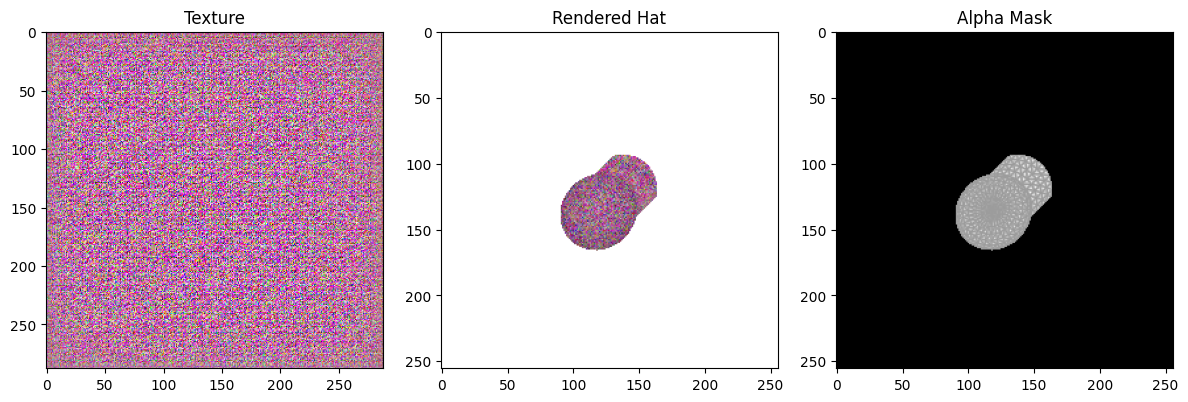

In [6]:
class HatRenderer:
    
    def __init__(self, mesh_path, render_size=256, device='cuda'):
        self.device = device
        self.render_size = render_size
        #Load mesh - getting the verts, faces, and uv mappings
        self.mesh_loaded = False
        """
        CORRECT VERSION:
        if Path(mesh_path).exists():
            verts, faces, aux = load_obj(mesh_path, device=device)
            self.verts = verts
            self.faces = faces.verts_idx
            self.verts_uvs = aux.verts_uvs
            self.faces_uvs = faces.textures_idx
            self.mesh_loaded = True
            logger.info(f"Loaded mesh: {len(verts)} verts, {len(self.faces)} faces")
        """
        if Path(mesh_path).exists():
            verts, faces, aux = load_obj(mesh_path, device=device)
            center = (verts.max(0)[0] + verts.min(0)[0]) / 2
            verts = verts - center
            max_extent = (verts.max(0)[0] - verts.min(0)[0]).max()
            verts = verts / max_extent  # now fits in [-0.5, 0.5]
            self.verts = verts
            self.faces = faces.verts_idx
            self.verts_uvs = aux.verts_uvs
            self.faces_uvs = faces.textures_idx
            self.mesh_loaded = True
            logger.info(f"Loaded mesh: {len(verts)} verts, {len(self.faces)} faces (normalized from {max_extent:.1f} units)")
        else:
            #Use the placeholder
            logger.warning(f"Mesh not found at {mesh_path}. Using placeholder.")
            self._create_placeholder_mesh()
        #Rasterization settings
        self.raster_settings = RasterizationSettings(
            image_size=render_size, 
            blur_radius=0.0, 
            faces_per_pixel=1
        )
        #Create rasterizer once
        self.rasterizer = MeshRasterizer(raster_settings=self.raster_settings)

    #Make a placeholder if we don't have a mesh which is a disk.
    def _create_placeholder_mesh(self):
        #Simple disk
        n_points = 32
        angles = torch.linspace(0, 2*np.pi, n_points+1)[:-1]
        #Vertices: center + rim
        verts = [[0, 0, 0]]  #center
        for a in angles:
            verts.append([torch.cos(a).item(), torch.sin(a).item(), 0])
        self.verts = torch.tensor(verts, dtype=torch.float32, device=self.device)
        #Faces: triangles from center to rim
        faces = []
        for i in range(n_points):
            faces.append([0, i + 1, (i + 1) % n_points + 1])
        self.faces = torch.tensor(faces, dtype=torch.int64, device=self.device)
        #UVs: simple radial mapping
        uvs = [[0.5, 0.5]]  # center
        for a in angles:
            uvs.append([0.5 + 0.5*torch.cos(a).item(), 0.5 + 0.5*torch.sin(a).item()])
        self.verts_uvs = torch.tensor(uvs, dtype=torch.float32, device=self.device)
        self.faces_uvs = self.faces.clone()
        self.mesh_loaded = True

    #Now we render the texture on the hat
    def render(self, texture, elevation=90, azimuth=0, scale=1.0):
        batch_size = texture.shape[0]
        #Handle both scalar and per-sample scale (so scale the geometry)
        if isinstance(scale, (int, float)):
            verts = self.verts * scale
            verts_list = [verts] * batch_size
        elif isinstance(scale, torch.Tensor) and scale.dim() == 0:
            verts = self.verts * scale.item()
            verts_list = [verts] * batch_size
        else:
            verts_list = [self.verts * s.item() for s in scale]
        #Camera setup
        dist = 2.5  #Camera distance
        if not isinstance(elevation, torch.Tensor):
            elevation = torch.tensor([elevation], device=self.device).expand(batch_size)
            azimuth = torch.tensor([azimuth], device=self.device).expand(batch_size)
        elif elevation.dim() == 0:
            elevation = elevation.unsqueeze(0).expand(batch_size)
            azimuth = azimuth.unsqueeze(0).expand(batch_size)
        R, T = look_at_view_transform(dist=dist, elev=elevation, azim=azimuth, device=self.device)
        cameras = FoVPerspectiveCameras(R=R, T=T, device=self.device)
        """
        #Random Lighting (varying lighting)
        light_x = np.random.uniform(-1, 1)
        light_y = np.random.uniform(1, 3)  #Always somewhat above
        light_z = np.random.uniform(-1, 1)
        lights = PointLights(
            device=self.device, 
            location=[[light_x, light_y, light_z]],
            ambient_color=[[0.5, 0.5, 0.5]],
            diffuse_color=[[0.3, 0.3, 0.3]],
            specular_color=[[0.2, 0.2, 0.2]]
        )
        """
        lights = PointLights(
            device=self.device, 
            location=[[0.0, 2.0, 0.0]],
            ambient_color=[[0.7, 0.7, 0.7]],
            diffuse_color=[[0.2, 0.2, 0.2]],
            specular_color=[[0.1, 0.1, 0.1]]
        )
        #Create shader once per render call (lighting changes)
        shader = SoftPhongShader(device=self.device, cameras=cameras, lights=lights)
        #Create batched texture and bind to mesh
        tex_maps = texture.permute(0, 2, 3, 1)  #(B, H, W, 3)
        textures = TexturesUV(
            maps=tex_maps,
            faces_uvs=[self.faces_uvs] * batch_size,
            verts_uvs=[self.verts_uvs] * batch_size
        )
        #Assemble and render
        meshes = Meshes(
            verts=verts_list,
            faces=[self.faces] * batch_size,
            textures=textures
        )
        #Render entire batch at once - 2-phase raster than shade
        fragments = self.rasterizer(meshes, cameras=cameras)
        images = shader(fragments, meshes, cameras=cameras, lights=lights)
        #Match PyTorch convention, format output
        rendered_images = images[..., :3].permute(0, 3, 1, 2)
        alpha_masks = images[..., 3:4].permute(0, 3, 1, 2)
        #Return result
        return rendered_images, alpha_masks

def analyze_mesh_for_printing(mesh_path, config, preloaded=None):
    from collections import defaultdict, deque
    _p = config['printer']
    #Check if the mesh is here
    if not Path(mesh_path).exists():
        logger.warning("No mesh file — defaulting to 12x12 inch print area")
        config['physical_size_inches'] = (12.0, 12.0)
        config['texture_output_size_w'] = int(_p['dpi'] * 12)
        config['texture_output_size_h'] = int(_p['dpi'] * 12)
        config['uv_islands'] = []
        return
    #Check if we have already parsed the .obj
    if preloaded is not None:
        verts_np = preloaded['verts'].cpu().numpy()
        verts_uvs = preloaded['verts_uvs'].cpu().numpy()
        faces_verts = preloaded['faces_verts'].cpu().numpy()
        faces_uvs = preloaded['faces_uvs'].cpu().numpy()
    else:
        verts, faces, aux = load_obj(mesh_path)
        verts_np = verts.cpu().numpy()
        verts_uvs = aux.verts_uvs.cpu().numpy()
        faces_verts = faces.verts_idx.cpu().numpy()
        faces_uvs = faces.textures_idx.cpu().numpy()
    #Auto-callibration fallback
    if _p['mesh_unit_to_inches'] is None:
        x_span = verts_np[:, 0].max() - verts_np[:, 0].min()
        y_span = verts_np[:, 1].max() - verts_np[:, 1].min()
        z_span = verts_np[:, 2].max() - verts_np[:, 2].min()
        max_span = max(x_span, y_span, z_span)
        _p['mesh_unit_to_inches'] = 10.0 / max_span if max_span > 0 else 1.0
        logger.warning(f"Auto-estimated mesh scale: {_p['mesh_unit_to_inches']:.3f} in/unit " f"(mesh widest: {max_span:.3f} units -> ~10 inches)")
        logger.warning("SET printer.mesh_unit_to_inches manually for accuracy")
    scale = _p['mesh_unit_to_inches']
    #Adjacency map
    uv_vert_to_faces = defaultdict(set)
    for fi, face in enumerate(faces_uvs):
        for vi in face:
            uv_vert_to_faces[vi].add(fi)
    #BFS
    visited = set()
    islands = []
    for fi in range(len(faces_uvs)):
        if fi in visited:
            continue
        island = []
        queue = deque([fi])
        while queue:
            f = queue.popleft()
            if f in visited:
                continue
            visited.add(f)
            island.append(f)
            for vi in faces_uvs[f]:
                for neighbor in uv_vert_to_faces[vi]:
                    if neighbor not in visited:
                        queue.append(neighbor)
        islands.append(island)
    #Measure the size of the islands
    island_info = []
    for idx, island_faces in enumerate(islands):
        island_uv_indices = set()
        for fi in island_faces:
            for vi in faces_uvs[fi]:
                island_uv_indices.add(vi)
        island_uvs_arr = verts_uvs[list(island_uv_indices)]
        u_min, v_min = island_uvs_arr.min(axis=0)
        u_max, v_max = island_uvs_arr.max(axis=0)
        #Triangle area via cross product - sum the area
        total_area_3d = 0.0
        for fi in island_faces:
            v0 = verts_np[faces_verts[fi][0]]
            v1 = verts_np[faces_verts[fi][1]]
            v2 = verts_np[faces_verts[fi][2]]
            total_area_3d += 0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0))
        #Ratio between 3D surface and UV area
        physical_area = total_area_3d * (scale ** 2)
        #Store measurements on the islands
        island_info.append({
            'index': idx,
            'num_faces': len(island_faces),
            'uv_bounds': (u_min, v_min, u_max, v_max),
            'physical_area_sq_inches': physical_area,
        })
        logger.info(f"  Island {idx}: {len(island_faces)} faces, ~{physical_area:.1f} sq in")
    #Overall print dimensions
    config['uv_islands'] = island_info
    logger.info(f"Found {len(islands)} UV island(s)")
    #Total area
    total_area = sum(i['physical_area_sq_inches'] for i in island_info)
    all_u_min = min(i['uv_bounds'][0] for i in island_info)
    all_v_min = min(i['uv_bounds'][1] for i in island_info)
    all_u_max = max(i['uv_bounds'][2] for i in island_info)
    all_v_max = max(i['uv_bounds'][3] for i in island_info)
    uv_width = all_u_max - all_u_min
    uv_height = all_v_max - all_v_min
    #Bounding box uv area for printing
    sa = _p['seam_allowance_inches']
    #Average 3D-to-UV scale: compare total 3D area to total UV area
    total_uv_area = 0.0
    for island_faces_idx in islands:
        for fi in island_faces_idx:
            uv0 = verts_uvs[faces_uvs[fi][0]]
            uv1 = verts_uvs[faces_uvs[fi][1]]
            uv2 = verts_uvs[faces_uvs[fi][2]]
            total_uv_area += 0.5 * abs(np.cross(uv1 - uv0, uv2 - uv0))
    #physical_area / uv_area = (scale_per_uv_unit)^2
    scale_per_uv = np.sqrt(total_area / (total_uv_area + 1e-8))
    phys_w = uv_width * scale_per_uv + 2 * sa
    phys_h = uv_height * scale_per_uv + 2 * sa
    #Store info
    config['physical_size_inches'] = (phys_w, phys_h)
    config['texture_output_size_w'] = int(_p['dpi'] * phys_w)
    config['texture_output_size_h'] = int(_p['dpi'] * phys_h)
    #Log the info
    logger.info(f"Print size: {phys_w:.1f} x {phys_h:.1f} inches " f"({config['texture_output_size_w']}x{config['texture_output_size_h']}px @ {_p['dpi']} DPI)")

#Test renderer
renderer = HatRenderer(CONFIG['mesh_path'], CONFIG['render_size'], device)
#Do fresh load if we don't have the mesh
if renderer.mesh_loaded and Path(CONFIG['mesh_path']).exists():
    analyze_mesh_for_printing(CONFIG['mesh_path'], CONFIG, preloaded={
        'verts': renderer.verts,
        'verts_uvs': renderer.verts_uvs,
        'faces_verts': renderer.faces,
        'faces_uvs': renderer.faces_uvs,
    })
else:
    analyze_mesh_for_printing(CONFIG['mesh_path'], CONFIG)
#Render overhead
test_render, test_alpha = renderer.render(test_texture, elevation=85, azimuth=45)
logger.info(f"Rendered shape: {test_render.shape}, alpha shape: {test_alpha.shape}")
#Visualize
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(test_texture[0].permute(1,2,0).detach().cpu())
axes[0].set_title('Texture')
axes[1].imshow(test_render[0].permute(1,2,0).detach().cpu())
axes[1].set_title('Rendered Hat')
axes[2].imshow(test_alpha[0, 0].detach().cpu(), cmap='gray')
axes[2].set_title('Alpha Mask')
plt.tight_layout()
plt.show()

## 8: T-SEA Augmentations

Helper methods for black/gray/white box transfers

In [7]:
#Randomly mask a region of the rendered hat. Prevents overfitting to specific texture patterns.
def patch_cutout(rendered_hat, alpha_mask, prob=0.9, ratio=0.4, fill=0.5):
    if np.random.random() > prob:
        return rendered_hat
    B, C, H, W = rendered_hat.shape
    #Random cutout size
    cut_h = int(H * ratio)
    cut_w = int(W * ratio)
    #Random position
    top = np.random.randint(0, H - cut_h + 1)
    left = np.random.randint(0, W - cut_w + 1)
    #Apply cutout (only where alpha > 0)
    mask = alpha_mask.clone()
    mask[:, :, top:top+cut_h, left:left+cut_w] = 0
    rendered_hat = rendered_hat * mask + fill * (1 - mask) * (alpha_mask > 0).float()
    return rendered_hat

#Mild augmentations that don't distort the image too much.
def constrained_augmentation(image):
    B, C, H, W = image.shape
    #Random scale (0.9 - 1.1)
    scale = np.random.uniform(0.9, 1.1)
    new_h = int(H * scale)
    new_w = int(W * scale)
    image = F.interpolate(image, size=(new_h, new_w), mode='bilinear', align_corners=False)
    #Crop/pad back to original size
    if new_h > H:
        start_h = (new_h - H) // 2
        start_w = (new_w - W) // 2
        image = image[:, :, start_h:start_h+H, start_w:start_w+W]
    else:
        pad_h_top = (H - new_h) // 2
        pad_h_bot = H - new_h - pad_h_top
        pad_w_left = (W - new_w) // 2
        pad_w_right = W - new_w - pad_w_left
        image = F.pad(image, [pad_w_left, pad_w_right, pad_h_top, pad_h_bot], mode='reflect')
    #Color jitter (mild)
    brightness = np.random.uniform(0.9, 1.1)
    image = image * brightness
    #Random horizontal flip
    if np.random.random() > 0.5:
        image = torch.flip(image, dims=[3])
    return image.clamp(0, 1)

#ShakeDrop reates virtual ensemble of model variants
def shakedrop_forward(x, drop_prob=0.5, alpha_range=(0, 2)):
    #Simplified ShakeDrop: add scaled noise to create virtual ensemble variants
    if np.random.random() < drop_prob:
        alpha = np.random.uniform(*alpha_range)
        noise = torch.randn_like(x) * 0.1 * alpha
        x = x + noise
    return x

## 9: URAdv Augmentations

For better performance under drone conditions

In [8]:
#Add simulated light reflections on the hat surface.
def add_light_spots(image, alpha_mask, num_range=(0, 3), intensity_range=(0.1, 0.4)):
    if np.random.random() > 0.5:
        return image
    B, C, H, W = image.shape
    num_spots = np.random.randint(*num_range)
    y, x = torch.meshgrid(torch.arange(H, device=image.device), torch.arange(W, device=image.device), indexing='ij')
    for _ in range(num_spots):
        #Random spot position (within hat region)
        cy = np.random.randint(H // 4, 3 * H // 4)
        cx = np.random.randint(W // 4, 3 * W // 4)
        #Spot parameters
        radius = np.random.uniform(0.05, 0.15) * min(H, W)
        intensity = np.random.uniform(*intensity_range)
        #Create Gaussian spot
        dist = ((x - cx) ** 2 + (y - cy) ** 2).float()
        spot = torch.exp(-dist / (2 * radius ** 2)) * intensity
        #Apply only within hat (where alpha > 0)
        spot = spot.unsqueeze(0).unsqueeze(0) * (alpha_mask > 0).float()
        image = image + spot
    return image.clamp(0, 1)

#Add simulated shadows on the hat surface.
def add_shadows(image, alpha_mask, num_range=(0, 2), opacity_range=(0.2, 0.5)):
    if np.random.random() > 0.5:
        return image
    B, C, H, W = image.shape
    num_shadows = np.random.randint(*num_range)
    y, x = torch.meshgrid(torch.arange(H, device=image.device), torch.arange(W, device=image.device), indexing='ij')
    for _ in range(num_shadows):
        #Random shadow as diagonal stripe
        angle = np.random.uniform(0, np.pi)
        opacity = np.random.uniform(*opacity_range)
        width = np.random.uniform(0.1, 0.3) * min(H, W)
        #Create shadow mask
        offset = np.random.uniform(0, H)
        dist = torch.abs(x * np.cos(angle) + y * np.sin(angle) - offset)
        shadow = (dist < width).float() * opacity
        #Apply only within hat
        shadow = shadow.unsqueeze(0).unsqueeze(0) * (alpha_mask > 0).float()
        image = image * (1 - shadow)
    return image.clamp(0, 1)

#Simulate printer color/brightness variation.
def simulate_printing(texture, mul_std=0.1, add_std=0.05):
    #Multiplicative noise
    mul_noise = torch.randn_like(texture) * mul_std + 1.0
    texture = texture * mul_noise
    #Additive noise
    add_noise = torch.randn_like(texture) * add_std
    texture = texture + add_noise
    return texture.clamp(0, 1)

class PrinterGamut:

    #Load parameters, or use simplified constraints
    def __init__(self, config, device='cuda'):
        self.config = config['printer']
        self.device = device
        gamut_path = self.config.get('gamut_samples_path')
        if gamut_path and Path(gamut_path).exists():
            self.gamut_samples = torch.from_numpy(np.load(gamut_path)).float().to(self.device)
            self.use_measured_gamut = True
            logger.info(f"Loaded {len(self.gamut_samples)} gamut samples")
        else:
            self.use_measured_gamut = False
            logger.info("Using simplified gamut constraints")

    #Non-printability score loss
    def nps_loss(self, texture):
        loss = 0.0
        if self.use_measured_gamut:
            #Compare each texture pixel to the nearest printable color
            #texture: (B, 3, H, W) -> (N, 3) flat pixel list
            B, C, H, W = texture.shape
            pixels = texture.permute(0, 2, 3, 1).reshape(-1, 3)  #(N, 3)
            #gamut_samples: (G, 3) — measured printable RGB values
            #Compute distance from each pixel to nearest gamut sample
            chunk_size = 4096
            gamut_dists = []
            for i in range(0, pixels.shape[0], chunk_size):
                chunk = pixels[i:i+chunk_size]  #(chunk, 3)
                dists = torch.cdist(chunk.unsqueeze(0), self.gamut_samples.unsqueeze(0)).squeeze(0)  #(chunk, G)
                min_dists = dists.min(dim=1)[0]  #(chunk,)
                gamut_dists.append(min_dists)
            gamut_dists = torch.cat(gamut_dists)
            loss = loss + gamut_dists.mean()
        else:
            #Simplified constraints when no gamut data available
            max_ch = texture.max(dim=1)[0]
            min_ch = texture.min(dim=1)[0]
            saturation = (max_ch - min_ch) / (max_ch + 1e-8)
            brightness = max_ch
            #Saturation * brightness threshold
            loss = loss + F.relu(saturation * brightness - self.config['nps_threshold']).mean()
            #Saturation cap
            loss = loss + F.relu(saturation - self.config['max_saturation']).mean()
            #Brightness bounds
            loss = loss + F.relu(brightness - self.config['max_brightness']).mean()
            loss = loss + F.relu(self.config['min_brightness'] - brightness).mean()
        return loss

    #Hard clamp for final export
    def clamp_to_gamut(self, texture):
        return texture.clamp(self.config['min_brightness'], self.config['max_brightness'])

#Initialize globally
printer_gamut = PrinterGamut(CONFIG, device)

#Apply camera artifacts: blur, noise.
def apply_environmental_augmentation(image, prob=0.3):
    #Motion blur
    if np.random.random() < prob:
        kernel_size = np.random.choice([3, 5, 7])
        kernel = torch.zeros(kernel_size, kernel_size, device=image.device)
        kernel[kernel_size//2, :] = 1.0 / kernel_size
        #Rotate kernel to random angle for directional blur
        angle = np.random.uniform(0, 360)
        angle_rad = np.deg2rad(angle)
        cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
        #Build rotation matrix and affine grid
        theta = torch.tensor([[cos_a, -sin_a, 0], [sin_a,  cos_a, 0]], dtype=torch.float32, device=image.device).unsqueeze(0)
        grid = F.affine_grid(theta, [1, 1, kernel_size, kernel_size], align_corners=False)
        kernel_rotated = F.grid_sample(kernel.unsqueeze(0).unsqueeze(0), grid, align_corners=False, mode='bilinear', padding_mode='zeros').squeeze()
        #Renormalize so kernel sums to 1
        kernel_rotated = kernel_rotated / (kernel_rotated.sum() + 1e-8)
        image = F.conv2d(image, kernel_rotated.view(1, 1, kernel_size, kernel_size).expand(3, 1, -1, -1), padding=kernel_size//2, groups=3)
    #Gaussian noise
    if np.random.random() < prob:
        noise_std = np.random.uniform(0.01, 0.05)
        image = image + torch.randn_like(image) * noise_std
    return image.clamp(0, 1)

#Viewpoint jitter for robustness
def apply_viewpoint_jitter(elevation, azimuth, scale, config):
    elev = elevation + np.random.uniform(-config['camera_pitch_jitter'], config['camera_pitch_jitter'])
    elev = np.clip(elev, 0, 90)
    azim = azimuth + np.random.uniform(-config['heading_jitter'], config['heading_jitter'])
    azim = azim % 360
    scl = scale * (1 + np.random.uniform(-config['scale_jitter'], config['scale_jitter']))
    scl = np.clip(scl, 0.1, 2.0)
    return elev, azim, scl

2026-02-15 21:53:31,662 | Using simplified gamut constraints


## 10: Toroidal Cropping

Wrapping the texture

In [9]:
#Try to get smooth textures
def total_variation_loss(texture):
    diff_h = texture[:, :, 1:, :] - texture[:, :, :-1, :]
    diff_w = texture[:, :, :, 1:] - texture[:, :, :, :-1]
    return (diff_h.pow(2).mean() + diff_w.pow(2).mean()) / 2

class ToroidalLatent(nn.Module):

    def __init__(self, local_size, crop_size=9, latent_channels=128, device='cuda'):
        super().__init__()
        self.local_size = local_size
        self.crop_size = crop_size
        self.latent_channels = latent_channels
        self.z_local = nn.Parameter(torch.randn(1, latent_channels, local_size, local_size, device=device) * 0.1)

    #Random crop
    def get_random_crops(self, batch_size):
        #Tile 3x3 for wraparound
        z_tiled = self.z_local.repeat(1, 1, 3, 3)
        crops = []
        for _ in range(batch_size):
            #Random offset within middle tile (to enable wraparound)
            i = np.random.randint(self.local_size, 2 * self.local_size)
            j = np.random.randint(self.local_size, 2 * self.local_size)
            crop = z_tiled[:, :, i:i+self.crop_size, j:j+self.crop_size]
            crops.append(crop)
        return torch.cat(crops, dim=0)

    #Crop to fill size
    def get_full_latent(self, target_spatial_size):
        reps = (target_spatial_size + self.local_size - 1) // self.local_size + 1
        z_tiled = self.z_local.repeat(1, 1, reps, reps)
        return z_tiled[:, :, :target_spatial_size, :target_spatial_size]

    #Deterministic crop
    def get_canonical_crop(self):
        offset = (self.local_size - self.crop_size) // 2
        return self.z_local[:, :, offset:offset+self.crop_size, offset:offset+self.crop_size]

## 11: Sceen Composition

Render the sceen (put hat on image)

In [10]:
def composite_hat_on_scene(scene_image, hat_mask, rendered_hat, alpha_mask):
    B, C, H, W = scene_image.shape
    full_hat = torch.zeros_like(scene_image)
    full_alpha = torch.zeros(B, 1, H, W, device=scene_image.device)
    for i in range(B):
        mask = hat_mask[i, 0]
        if mask.sum() == 0:
            continue
        ys, xs = torch.where(mask > 0.5)
        y1, y2 = ys.min().item(), ys.max().item()
        x1, x2 = xs.min().item(), xs.max().item()
        hat_h, hat_w = y2 - y1 + 1, x2 - x1 + 1
        if hat_h < 2 or hat_w < 2:
            continue
        a = alpha_mask[i, 0]
        a_ys, a_xs = torch.where(a > 0.1)
        if len(a_ys) == 0:
            continue
        ay1, ay2 = a_ys.min().item(), a_ys.max().item()
        ax1, ax2 = a_xs.min().item(), a_xs.max().item()
        hat_crop = rendered_hat[i:i+1, :, ay1:ay2+1, ax1:ax2+1]
        alpha_crop = alpha_mask[i:i+1, :, ay1:ay2+1, ax1:ax2+1]
        hat_resized = F.interpolate(hat_crop, size=(hat_h, hat_w), mode='bilinear', align_corners=False)
        alpha_resized = F.interpolate(alpha_crop, size=(hat_h, hat_w), mode='bilinear', align_corners=False)
        alpha_resized = (alpha_resized > 0.1).float()
        full_hat[i:i+1, :, y1:y2+1, x1:x2+1] = hat_resized
        full_alpha[i:i+1, :, y1:y2+1, x1:x2+1] = alpha_resized
    composited = full_hat * full_alpha + scene_image * (1 - full_alpha)
    return composited

def crop_to_person(composited, person_bbox, target_size=640, pad_ratio=0.5):
    B, C, H, W = composited.shape
    crops = []
    for i in range(B):
        x1, y1, x2, y2 = person_bbox[i]
        bw, bh = x2 - x1, y2 - y1
        side = max(bw, bh) * (1 + pad_ratio)
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        half = side / 2
        cx1 = int(torch.clamp(cx - half, min=0))
        cy1 = int(torch.clamp(cy - half, min=0))
        cx2 = int(torch.clamp(cx + half, max=W))
        cy2 = int(torch.clamp(cy + half, max=H))
        crop = composited[i:i+1, :, cy1:cy2, cx1:cx2]
        crop = F.interpolate(crop, size=(target_size, target_size), mode='bilinear', align_corners=False)
        crops.append(crop)
    return torch.cat(crops, dim=0)

def crop_to_head(composited, person_bbox, hat_mask, target_size=640):
    B, C, H, W = composited.shape
    crops = []
    for i in range(B):
        mask = hat_mask[i, 0]
        if mask.sum() < 10:
            #Fallback to top 25% of person bbox
            x1, y1, x2, y2 = person_bbox[i]
            bh = y2 - y1
            head_y2 = y1 + bh * 0.25
        else:
            ys, xs = torch.where(mask > 0.5)
            y1, y2 = ys.min(), ys.max()
            x1, x2 = xs.min(), xs.max()
            head_y2 = y2
        #Square crop centered on hat with some context
        x1_p, y1_p, x2_p, y2_p = person_bbox[i]
        hat_cx = (x1 + x2) / 2 if mask.sum() >= 10 else (x1_p + x2_p) / 2
        hat_cy = (y1 + head_y2) / 2 if mask.sum() >= 10 else y1_p + (y2_p - y1_p) * 0.125
        bw = x2_p - x1_p
        side = max(bw * 0.6, 100)  # head-width crop with context
        half = side / 2
        cx1 = int(torch.clamp(hat_cx - half, min=0))
        cy1 = int(torch.clamp(hat_cy - half, min=0))
        cx2 = int(torch.clamp(hat_cx + half, max=W))
        cy2 = int(torch.clamp(hat_cy + half, max=H))
        crop = composited[i:i+1, :, cy1:cy2, cx1:cx2]
        crop = F.interpolate(crop, size=(target_size, target_size), mode='bilinear', align_corners=False)
        crops.append(crop)
    return torch.cat(crops, dim=0)

def crop_hat_mask(hat_mask, person_bbox, target_size=640, pad_ratio=0.5):
    B, C, H, W = hat_mask.shape
    crops = []
    for i in range(B):
        x1, y1, x2, y2 = person_bbox[i]
        bw, bh = x2 - x1, y2 - y1
        side = max(bw, bh) * (1 + pad_ratio)
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        half = side / 2
        cx1 = int(torch.clamp(cx - half, min=0))
        cy1 = int(torch.clamp(cy - half, min=0))
        cx2 = int(torch.clamp(cx + half, max=W))
        cy2 = int(torch.clamp(cy + half, max=H))
        crop = hat_mask[i:i+1, :, cy1:cy2, cx1:cx2]
        crop = F.interpolate(crop, size=(target_size, target_size), mode='nearest')
        crops.append(crop)
    return torch.cat(crops, dim=0)

## 12: Ensamble

Ensamble detection

In [13]:
#Monkey Patching
"""
from ultralytics.nn.modules.block import C2f, Bottleneck
from ultralytics.nn.modules.head import Detect
_orig_c2f = C2f.forward
def _safe_c2f(self, x):
    y = list(self.cv1(x).chunk(2, 1))
    y = [yi.clone() for yi in y]
    for m in self.m:
        y.append(m(y[-1]))
    return self.cv2(torch.cat(y, 1))
C2f.forward = _safe_c2f
_orig_bn = Bottleneck.forward
def _safe_bn(self, x):
    return x.clone() + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))
Bottleneck.forward = _safe_bn
_orig_fh = Detect.forward_head
def _safe_fh(self, x, box_head, cls_head):
    bs = x[0].shape[0]
    boxes = torch.cat([box_head[i](x[i].clone()).reshape(bs, 4 * self.reg_max, -1) for i in range(self.nl)], dim=-1)
    scores = torch.cat([cls_head[i](x[i].clone()).reshape(bs, self.nc, -1) for i in range(self.nl)], dim=-1)
    return dict(boxes=boxes, scores=scores, feats=x)
Detect.forward_head = _safe_fh
"""

class DetectorEnsemble:
    
    def __init__(self, attack_mode='gray', device='cuda', conf_floor=0.001):
        self.device = device
        self.conf_floor = conf_floor
        self.models = {}
        self.weights = {}
        if attack_mode == 'white':
            self.models['yolov8m'] = YOLO('yolov8m.pt')
            self.models['yolov8m'].model.to(device)
            for m in self.models['yolov8m'].model.modules():
                if hasattr(m, 'inplace'):
                    m.inplace = False
                if isinstance(m, nn.SiLU):
                    m.inplace = False
                if isinstance(m, nn.ReLU):
                    m.inplace = False
            self.weights['yolov8m'] = 1.0
        elif attack_mode == 'gray':
            model_configs = [
                ('yolov8s', 0.20),
                ('yolov8m', 0.25),
                ('yolov8l', 0.20),
                ('yolov5m', 0.20),
                ('yolov5l', 0.15),
            ]
            for name, weight in model_configs:
                try:
                    self.models[name] = YOLO(f'{name}.pt')
                    self.models[name].model.to(device)
                    for m in self.models[name].model.modules():
                        if hasattr(m, 'inplace'):
                            m.inplace = False
                        if isinstance(m, nn.SiLU):
                            m.inplace = False
                        if isinstance(m, nn.ReLU):
                            m.inplace = False
                    self.weights[name] = weight
                    logger.info(f"Loaded {name}")
                except Exception as e:
                    logger.warning(f"Failed to load {name}: {e}")
        elif attack_mode == 'black':
            #Add More
            model_configs = [
                ('yolov8m', 0.30),
                ('yolov8l', 0.25),
                ('yolov5l', 0.25),
                ('yolov5m', 0.20),
            ]
            for name, weight in model_configs:
                try:
                    self.models[name] = YOLO(f'{name}.pt')
                    self.models[name].model.to(device)
                    for m in self.models[name].model.modules():
                        if hasattr(m, 'inplace'):
                            m.inplace = False
                        if isinstance(m, nn.SiLU):
                            m.inplace = False
                        if isinstance(m, nn.ReLU):
                            m.inplace = False
                    self.weights[name] = weight
                except Exception as e:
                    logger.warning(f"Failed to load {name}: {e}") 
        #Normalize weights
        total = sum(self.weights.values())
        if total == 0:
            logger.error("No detector models loaded. Cannot proceed.")
            raise RuntimeError("No detector models loaded successfully")
        self.weights = {k: v/total for k, v in self.weights.items()}
        logger.info(f"Detector ensemble ({attack_mode}): {list(self.weights.keys())}")
        
    def compute_loss(self, images, return_detections=False):
            total_loss = 0.0
            all_detections = [] if return_detections else None
            for name, model in self.models.items():
                weight = self.weights[name]
                preds = model.model(images)
                if isinstance(preds, dict):
                    person_conf = preds['scores'][:, 0, :]
                elif isinstance(preds, (list, tuple)):
                    preds = preds[0]
                if preds.dim() == 3 and preds.shape[1] == 84:
                    person_conf = preds[:, 4, :]
                elif preds.dim() == 3 and preds.shape[2] >= 85:
                    person_conf = preds[..., 4] * preds[..., 5]
                else:
                    logger.warning(f"{name}: unexpected pred shape {preds.shape}, skipping")
                    continue
                B = person_conf.shape[0]
                per_image_loss = []
                for b in range(B):
                    img_confs = person_conf[b].reshape(-1)
                    k = min(100, img_confs.numel())
                    top_confs, _ = img_confs.topk(k)
                    per_image_loss.append(top_confs.mean())
                model_loss = torch.stack(per_image_loss).mean()
                total_loss = total_loss + weight * model_loss
                if return_detections:
                    all_detections.append({'model': name, 'preds': preds.detach()})
            if return_detections:
                return total_loss, all_detections
            return total_loss
    
    def detect(self, images, conf_threshold=0.5):
        images_np = [(images[i] * 255).byte().permute(1, 2, 0).cpu().numpy() for i in range(images.shape[0])]
        all_results = {}
        for name, model in self.models.items():
            results = model.predict(images_np, conf=self.conf_floor, classes=[0], verbose=False)
            all_results[name] = []
            for r in results:
                if len(r.boxes) > 0:
                    scores = r.boxes.conf.cpu().numpy()
                    boxes = r.boxes.xyxy.cpu().numpy()
                    #Filter by the actual requested threshold
                    keep = scores >= conf_threshold
                    all_results[name].append({'boxes': boxes[keep],'scores': scores[keep]})
                else:
                    all_results[name].append({'boxes': np.array([]),'scores': np.array([])})
        return all_results

#Initialize detector ensemble
detector = DetectorEnsemble(CONFIG['attack_mode'], device, conf_floor=CONFIG['det_conf_floor'])

2026-02-15 21:53:55,911 | Detector ensemble (white): ['yolov8m']


## 13: Stage 1: Generator Training

Train the Generator

In [14]:
def train_stage1(generator, aux_net, detector, dataset, config):

    generator.train()
    aux_net.train()
    #Optimizers
    opt_g = torch.optim.Adam(generator.parameters(), lr=config['stage1_lr'], betas=(0.5, 0.999))
    opt_aux = torch.optim.Adam(aux_net.parameters(), lr=config['stage1_lr'] * 5, betas=(0.5, 0.999))
    #DataLoader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=config['stage1_batch_size'], shuffle=True, num_workers=config['num_workers'], pin_memory=True, persistent_workers=True)
    
    #Training loop
    logger.info("Starting Stage 1 training...")
    for epoch in range(config['stage1_epochs']):
        epoch_losses = {'total': 0, 'detection': 0, 'tv': 0, 'nps': 0, 'mi': 0}
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['stage1_epochs']}")
        for batch_idx, batch in enumerate(pbar):
            
            #Sample latent
            actual_batch = batch['image'].shape[0]
            z = torch.randn(actual_batch, config['latent_channels'], config['latent_size'], config['latent_size'], device=device)
            #Generate texture
            texture = generator.generate(z)  #[0, 1]
            #Sample viewpoint and render
            elevs, azims, scls = [], [], []
            for i in range(texture.shape[0]):
                elev, azim, scl = apply_viewpoint_jitter(batch['elevation'][i].item(),batch['azimuth'][i].item(),batch['scale'][i].item(), config)
                elevs.append(elev)
                azims.append(azim)
                scls.append(scl)
            rendered_hat, alpha = renderer.render(texture,elevation=torch.tensor(elevs, dtype=torch.float32, device=device),azimuth=torch.tensor(azims, dtype=torch.float32, device=device),scale=torch.tensor(scls, dtype=torch.float32, device=device))

            """
            #Apply T-SEA augmentations
            rendered_hat = patch_cutout(rendered_hat, alpha, config['cutout_prob'], config['cutout_ratio'])
            #Apply URAdv augmentations
            rendered_hat = add_light_spots(rendered_hat, alpha)
            rendered_hat = add_shadows(rendered_hat, alpha)
            rendered_hat = simulate_printing(rendered_hat)
            """
    
            #Composite onto scene
            scene = batch['image'].to(device)
            hat_mask = batch['hat_mask'].to(device)

            composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
            person_crops = crop_to_person(composite, batch['person_bbox'].to(device), target_size=config['detector_input_size'])
            loss_det = detector.compute_loss(person_crops)
            """
            composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
            person_crops = crop_to_person(composite, batch['person_bbox'].to(device), target_size=config['detector_input_size'])
            hat_mask_crops = crop_hat_mask(hat_mask, batch['person_bbox'].to(device), target_size=config['detector_input_size'])
            person_crops = constrained_augmentation(person_crops)
            person_crops = apply_environmental_augmentation(person_crops)
            person_crops = shakedrop_forward(person_crops, drop_prob=config['shakedrop_prob'])
            loss_det = detector.compute_loss(person_crops, hat_mask_crops=hat_mask_crops)
            """
            """
            composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
            #Apply environmental augmentations
            composite = constrained_augmentation(composite)
            composite = apply_environmental_augmentation(composite)
            #ShakeDrop: perturb composite to create virtual ensemble variants
            composite = shakedrop_forward(composite, drop_prob=config['shakedrop_prob'])
            #Detection loss
            person_crops = crop_to_person(composite, batch['person_bbox'].to(device), target_size=CONFIG['detector_input_size'])
            loss_det = detector.compute_loss(person_crops)
            """
            """
            composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
            
            composite = constrained_augmentation(composite)
            composite = apply_environmental_augmentation(composite)
            #ShakeDrop: perturb composite to create virtual ensemble variants
            composite = shakedrop_forward(composite, drop_prob=config['shakedrop_prob'])
            
            #Detection loss
            loss_det = detector.compute_loss(composite)
            """
            #Regularization losses
            loss_tv = total_variation_loss(texture)
            loss_nps = printer_gamut.nps_loss(texture)
            #Mutual information (maximize = negate for min)
            loss_mi = compute_mi_loss(aux_net, texture, z)
            #Total loss
            if epoch < 10:
                #Warmup
                loss = (config['lambda_tv'] * loss_tv + config['lambda_nps'] * loss_nps + config['lambda_info'] * loss_mi)
            else:
                #Scale det loss by 5x so it dominates over MI regularization
                loss = (5.0 * loss_det + config['lambda_tv'] * loss_tv + config['lambda_nps'] * loss_nps + config['lambda_info'] * loss_mi)
            
            #Optimize
            opt_g.zero_grad()
            opt_aux.zero_grad()
            if isinstance(loss, torch.Tensor) and loss.requires_grad:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
                torch.nn.utils.clip_grad_norm_(aux_net.parameters(), 1.0)
                opt_g.step()
                opt_aux.step()
            #Track losses
            epoch_losses['total'] += loss.item() if isinstance(loss, torch.Tensor) else loss
            epoch_losses['detection'] += loss_det.item() if isinstance(loss_det, torch.Tensor) else loss_det
            epoch_losses['tv'] += loss_tv.item()
            epoch_losses['nps'] += loss_nps.item()
            epoch_losses['mi'] += loss_mi.item()
            pbar.set_postfix({'loss': f"{loss.item():.4f}" if isinstance(loss, torch.Tensor) else f"{loss:.4f}", 'det': f"{loss_det.item():.4f}" if isinstance(loss_det, torch.Tensor) else f"{loss_det:.4f}"})
        
        #Epoch summary
        n_batches = len(dataloader)
        for k in epoch_losses:
            epoch_losses[k] /= n_batches
        logger.info(f"Epoch {epoch+1} - Loss: {epoch_losses['total']:.4f}, " f"Det: {epoch_losses['detection']:.4f}, " f"TV: {epoch_losses['tv']:.4f}, " f"MI: {epoch_losses['mi']:.4f}")
        #Save sample texture every 10 epochs
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                sample = generator.generate(batch_size=1)
                save_texture(sample[0], f"{config['output_dir']}/texture_epoch{epoch+1}.png")   
    return generator

#Preview
def save_texture(texture, path):
    if isinstance(texture, torch.Tensor):
        texture = texture.detach().cpu()
        if texture.dim() == 3:
            texture = texture.permute(1, 2, 0).numpy()
        texture = (texture * 255).astype(np.uint8)
    cv2.imwrite(str(path), cv2.cvtColor(texture, cv2.COLOR_RGB2BGR))
    logger.info(f"Saved texture to {path}")

#Pinter ready
def save_final_texture(texture, config, path):
    from PIL import Image
    out_w = config['texture_output_size_w']
    out_h = config['texture_output_size_h']
    #Resize to print resolution
    texture_highres = F.interpolate(texture, size=(out_h, out_w), mode='bilinear', align_corners=False)
    #Clamp to printable gamut
    texture_highres = printer_gamut.clamp_to_gamut(texture_highres)
    #Convert to uint8
    texture_np = texture_highres[0].permute(1, 2, 0).detach().cpu().numpy()
    texture_np = (texture_np * 255).astype(np.uint8)
    img = Image.fromarray(texture_np)
    #Save TIFF with DPI metadata (for print)
    tiff_path = Path(path).with_suffix('.tiff')
    img.save(tiff_path, dpi=(config['printer']['dpi'], config['printer']['dpi']))
    #Save PNG for preview
    img.save(path)
    logger.info(f"Saved: {path} and {tiff_path}")
    logger.info(f"  {out_w}x{out_h}px at {config['printer']['dpi']} DPI")

#Export texture with UV seam cut lines drawn on top.
def export_print_template(texture, mesh_path, config, path):
    from PIL import Image, ImageDraw
    from collections import Counter
    _p = config['printer']
    out_w = config['texture_output_size_w']
    out_h = config['texture_output_size_h']
    texture_highres = F.interpolate(texture, size=(out_h, out_w), mode='bilinear', align_corners=False)
    texture_highres = printer_gamut.clamp_to_gamut(texture_highres)
    texture_np = texture_highres[0].permute(1, 2, 0).detach().cpu().numpy()
    texture_np = (texture_np * 255).astype(np.uint8)
    img = Image.fromarray(texture_np)
    draw = ImageDraw.Draw(img)
    if Path(mesh_path).exists():
        _, faces, aux = load_obj(mesh_path)
        verts_uvs = aux.verts_uvs.cpu().numpy()
        faces_uvs = faces.textures_idx.cpu().numpy()
        edge_count = Counter()
        for face in faces_uvs:
            for i in range(3):
                e = (min(face[i], face[(i+1)%3]), max(face[i], face[(i+1)%3]))
                edge_count[e] += 1
        for face in faces_uvs:
            for i in range(3):
                v0 = verts_uvs[face[i]]
                v1 = verts_uvs[face[(i+1) % 3]]
                x0, y0 = int(v0[0] * out_w), int((1 - v0[1]) * out_h)
                x1, y1 = int(v1[0] * out_w), int((1 - v1[1]) * out_h)
                e = (min(face[i], face[(i+1)%3]), max(face[i], face[(i+1)%3]))
                
                if edge_count[e] == 1:
                    draw.line([(x0, y0), (x1, y1)], fill=(255, 0, 0), width=3)
        if 'uv_islands' in config:
            for info in config['uv_islands']:
                bounds = info['uv_bounds']
                cx = int(((bounds[0] + bounds[2]) / 2) * out_w)
                cy = int((1 - (bounds[1] + bounds[3]) / 2) * out_h)
                area = info['physical_area_sq_inches']
                draw.text((cx, cy), f"Panel {info['index']} ({area:.1f} sq in)", fill=(255, 255, 0))
    tiff_path = Path(path).with_suffix('.tiff')
    img.save(tiff_path, dpi=(_p['dpi'], _p['dpi']))
    img.save(path)
    clean_img = Image.fromarray(texture_np)
    clean_path = Path(path).with_name(Path(path).stem + '_clean.png')
    clean_img.save(clean_path)
    logger.info(f"Print template: {tiff_path}")
    logger.info(f"  Red lines = CUT here")
    logger.info(f"  {out_w}x{out_h}px, {config['physical_size_inches'][0]:.1f} x {config['physical_size_inches'][1]:.1f} inches")

## 14: Stage 2: Latent Optimization

Optimize the Latent

In [15]:
def train_stage2(generator, detector, dataset, config, z_local=None):

    generator.eval()  #Freeze generator
    #Initialize toroidal latent
    toroidal = ToroidalLatent(local_size=config['local_latent_size'], crop_size=config['latent_size'], latent_channels=config['latent_channels'], device=device)
    
    if z_local is not None:
        toroidal.z_local.data = z_local
    #Optimizer for latent only
    optimizer = torch.optim.Adam(toroidal.parameters(), lr=config['stage2_lr'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['stage2_iterations'], eta_min=1e-4)
    #DataLoader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=config['stage2_batch_size'], shuffle=True,num_workers=config['num_workers'], pin_memory=True, persistent_workers=True)
    data_iter = iter(dataloader)

    logger.info("Starting Stage 2 latent optimization...")
    best_loss = float('inf')
    pbar = tqdm(range(config['stage2_iterations']), desc="Stage 2")
    for iteration in pbar:
        #Get batch (cycle through dataset)
        try:
            batch = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            batch = next(data_iter)
        #Get random crops from toroidal latent
        actual_batch = batch['image'].shape[0]
        z_crops = toroidal.get_random_crops(actual_batch)
        #We need gradients through generator for z
        texture = generator.generate(z_crops)
        #Sample viewpoints and render
        elevs, azims, scls = [], [], []
        for i in range(texture.shape[0]):
            elev, azim, scl = apply_viewpoint_jitter(batch['elevation'][i].item(), batch['azimuth'][i].item(), batch['scale'][i].item(), config)
            elevs.append(elev)
            azims.append(azim)
            scls.append(scl)
        rendered_hat, alpha = renderer.render(texture,elevation=torch.tensor(elevs, dtype=torch.float32, device=device),azimuth=torch.tensor(azims, dtype=torch.float32, device=device),scale=torch.tensor(scls, dtype=torch.float32, device=device))
        
        #Apply augmentations
        """
        rendered_hat = patch_cutout(rendered_hat, alpha, config['cutout_prob'], config['cutout_ratio'])
        rendered_hat = add_light_spots(rendered_hat, alpha)
        rendered_hat = add_shadows(rendered_hat, alpha)
        rendered_hat = simulate_printing(rendered_hat)
        """
        #Composite
        scene = batch['image'].to(device)
        hat_mask = batch['hat_mask'].to(device)

        composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
        person_crops = crop_to_person(composite, batch['person_bbox'].to(device), target_size=config['detector_input_size'])
        loss_det = detector.compute_loss(person_crops)

        """
        composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
        person_crops = crop_to_person(composite, batch['person_bbox'].to(device), target_size=config['detector_input_size'])
        hat_mask_crops = crop_hat_mask(hat_mask, batch['person_bbox'].to(device), target_size=config['detector_input_size'])
        person_crops = constrained_augmentation(person_crops)
        person_crops = apply_environmental_augmentation(person_crops)
        person_crops = shakedrop_forward(person_crops, drop_prob=config['shakedrop_prob'])
        loss_det = detector.compute_loss(person_crops, hat_mask_crops=hat_mask_crops)
        """
        """
        composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
        composite = constrained_augmentation(composite)
        composite = apply_environmental_augmentation(composite)
        composite = shakedrop_forward(composite, drop_prob=config['shakedrop_prob'])
        person_crops = crop_to_person(composite, batch['person_bbox'].to(device), target_size=CONFIG['detector_input_size'])
        loss_det = detector.compute_loss(person_crops)
        """
        """
        composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
        composite = constrained_augmentation(composite)
        composite = apply_environmental_augmentation(composite)
        #ShakeDrop: virtual ensemble
        composite = shakedrop_forward(composite, drop_prob=config['shakedrop_prob'])
        #Compute loss (no MI term in Stage 2)
        loss_det = detector.compute_loss(composite)
        """

        
        loss_tv = total_variation_loss(texture)
        loss_nps = printer_gamut.nps_loss(texture)
        loss = (loss_det + config['lambda_tv'] * loss_tv + config['lambda_nps'] * loss_nps)
        
        #Optimize
        optimizer.zero_grad()
        if isinstance(loss, torch.Tensor) and loss.requires_grad:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(toroidal.parameters(), 1.0)
            optimizer.step()
        scheduler.step()
        #Track best
        loss_val = loss.item() if isinstance(loss, torch.Tensor) else loss
        if loss_val < best_loss:
            best_loss = loss_val
            best_z_local = toroidal.z_local.data.clone()
        pbar.set_postfix({'loss': f"{loss_val:.4f}",'best': f"{best_loss:.4f}",'lr': f"{scheduler.get_last_lr()[0]:.6f}"})
        
        #Periodic logging
        if (iteration + 1) % 200 == 0:
            with torch.no_grad():
                #Generate final texture at full resolution
                z_canon = toroidal.get_canonical_crop()
                final_texture = generator.generate(z_canon)
                save_texture(final_texture[0], f"{config['output_dir']}/texture_stage2_iter{iteration+1}.png")
                
    #Save final results
    logger.info(f"Stage 2 complete. Best loss: {best_loss:.4f}")
    #Generate final texture
    with torch.no_grad():
        toroidal.z_local.data = best_z_local
        z_canon = toroidal.get_canonical_crop()
        final_texture = generator.generate(z_canon)
        #Tile to cover full print area
        def tile_texture(tex, target_h, target_w):
            _, _, h, w = tex.shape
            reps_h = (target_h + h - 1) // h
            reps_w = (target_w + w - 1) // w
            tiled = tex.repeat(1, 1, reps_h, reps_w)
            return tiled[:, :, :target_h, :target_w]
        target_h = config.get('texture_output_size_h', 1024)
        target_w = config.get('texture_output_size_w', 1024)
        final_texture = tile_texture(final_texture, target_h, target_w)
    save_final_texture(final_texture, config, f"{config['output_dir']}/final_texture.png")
    torch.save({'z_local': best_z_local,'generator': generator.state_dict()}, f"{config['output_dir']}/stage2_final.pth")
    return best_z_local, final_texture

## 15: Evaluation

See how we did

In [16]:
def compute_asr(detector, images, conf_threshold=0.5):
    results = detector.detect(images, conf_threshold)
    n_success = 0
    total = 0
    for model_name, model_results in results.items():
        for det in model_results:
            total += 1
            if len(det['boxes']) == 0:
                n_success += 1
    return n_success / total if total > 0 else 0.0


def evaluate_texture(generator, detector, dataset, z_local, config, num_samples=100):
    generator.eval()
    toroidal = ToroidalLatent(local_size=config['local_latent_size'], crop_size=config['latent_size'], latent_channels=config['latent_channels'], device=device)
    toroidal.z_local.data = z_local
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=config['num_workers'], pin_memory=True)
    asr_scores = {thresh: [] for thresh in [0.1, 0.3, 0.5, 0.7, 0.9]}
    baseline_scores = {thresh: [] for thresh in [0.1, 0.3, 0.5, 0.7, 0.9]}
    samples_seen = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            if samples_seen >= num_samples:
                break
            actual_batch = batch['image'].shape[0]
            samples_seen += actual_batch
            z_canon = toroidal.get_canonical_crop()
            z_crops = z_canon.expand(actual_batch, -1, -1, -1)
            texture = generator.generate(z_crops)
            elevs = batch['elevation'].tolist()
            azims = batch['azimuth'].tolist()
            scls = batch['scale'].tolist()
            rendered_hat, alpha = renderer.render(texture,
                elevation=torch.tensor(elevs, dtype=torch.float32, device=device),
                azimuth=torch.tensor(azims, dtype=torch.float32, device=device),
                scale=torch.tensor(scls, dtype=torch.float32, device=device))
            scene = batch['image'].to(device)
            hat_mask = batch['hat_mask'].to(device)
            composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
            #Attacked crops
            person_crops = crop_to_person(composite, batch['person_bbox'].to(device), target_size=config['detector_input_size'])
            #Baseline crops (no attack)
            clean_crops = crop_to_person(scene, batch['person_bbox'].to(device), target_size=config['detector_input_size'])
            for thresh in asr_scores.keys():
                asr_scores[thresh].append(compute_asr(detector, person_crops, conf_threshold=thresh))
                baseline_scores[thresh].append(compute_asr(detector, clean_crops, conf_threshold=thresh))
    #Report
    mean_asr = {}
    for thresh in asr_scores:
        atk = np.mean(asr_scores[thresh])
        base = np.mean(baseline_scores[thresh])
        mean_asr[thresh] = atk
        logger.info(f"ASR@{thresh}: {atk:.2%}  (baseline miss rate: {base:.2%})")
    overall = np.mean(list(mean_asr.values()))
    logger.info(f"Mean ASR: {overall:.2%}")
    #Per-model at 0.5
    sample_batch = next(iter(dataloader))
    actual_batch = sample_batch['image'].shape[0]
    with torch.no_grad():
        z_canon = toroidal.get_canonical_crop().expand(actual_batch, -1, -1, -1)
        texture = generator.generate(z_canon)
        rendered_hat, alpha = renderer.render(texture,
            elevation=torch.tensor(sample_batch['elevation'].tolist(), dtype=torch.float32, device=device),
            azimuth=torch.tensor(sample_batch['azimuth'].tolist(), dtype=torch.float32, device=device),
            scale=torch.tensor(sample_batch['scale'].tolist(), dtype=torch.float32, device=device))
        scene = sample_batch['image'].to(device)
        hat_mask = sample_batch['hat_mask'].to(device)
        composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
        person_crops = crop_to_person(composite, sample_batch['person_bbox'].to(device), target_size=config['detector_input_size'])
        results = detector.detect(person_crops, conf_threshold=0.5)
        for model_name, model_results in results.items():
            n_missed = sum(1 for det in model_results if len(det['boxes']) == 0)
            logger.info(f"  {model_name} ASR@0.5: {n_missed / len(model_results):.2%}")
    #Full-frame sanity check
    with torch.no_grad():
        full_detected, full_total = 0, 0
        for batch in dataloader:
            actual_batch = batch['image'].shape[0]
            z_canon = toroidal.get_canonical_crop().expand(actual_batch, -1, -1, -1)
            texture = generator.generate(z_canon)
            rendered_hat, alpha = renderer.render(texture,
                elevation=torch.tensor(batch['elevation'].tolist(), dtype=torch.float32, device=device),
                azimuth=torch.tensor(batch['azimuth'].tolist(), dtype=torch.float32, device=device),
                scale=torch.tensor(batch['scale'].tolist(), dtype=torch.float32, device=device))
            scene = batch['image'].to(device)
            hat_mask = batch['hat_mask'].to(device)
            composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
            # Resize to 640 like naive full-frame
            full_resized = F.interpolate(composite, size=(640, 640), mode='bilinear', align_corners=False)
            results = detector.detect(full_resized, conf_threshold=0.5)
            for name, dets in results.items():
                for det in dets:
                    full_total += 1
                    if len(det['boxes']) > 0:
                        full_detected += 1
        logger.info(f"Full-frame detection rate (attacked): {full_detected/full_total:.1%}")
    return mean_asr

## 16: Main

Bring it all together

2026-02-15 21:54:00,393 | Initializing models...
2026-02-15 21:54:00,560 | Generator params: 7574787
2026-02-15 21:54:00,561 | Auxiliary params: 1086401
2026-02-15 21:54:00,562 | ==================================================
2026-02-15 21:54:00,563 | STAGE 1: Generator Training
2026-02-15 21:54:00,564 | ==================================================
2026-02-15 21:54:00,565 | Starting Stage 1 training...
Epoch 1/100: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it, loss=0.1392, det=0.0884]
2026-02-15 21:54:28,802 | Epoch 1 - Loss: 0.1431, Det: 0.0837, TV: 0.0395, MI: 1.3893
Epoch 2/100: 100%|██████████| 25/25 [00:28<00:00,  1.12s/it, loss=0.1399, det=0.0818]
2026-02-15 21:54:56,865 | Epoch 2 - Loss: 0.1390, Det: 0.0837, TV: 0.0029, MI: 1.3866
Epoch 3/100: 100%|██████████| 25/25 [00:28<00:00,  1.12s/it, loss=0.1389, det=0.0778]
2026-02-15 21:55:24,885 | Epoch 3 - Loss: 0.1384, Det: 0.0822, TV: 0.0015, MI: 1.3825
Epoch 4/100: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it, loss=0.

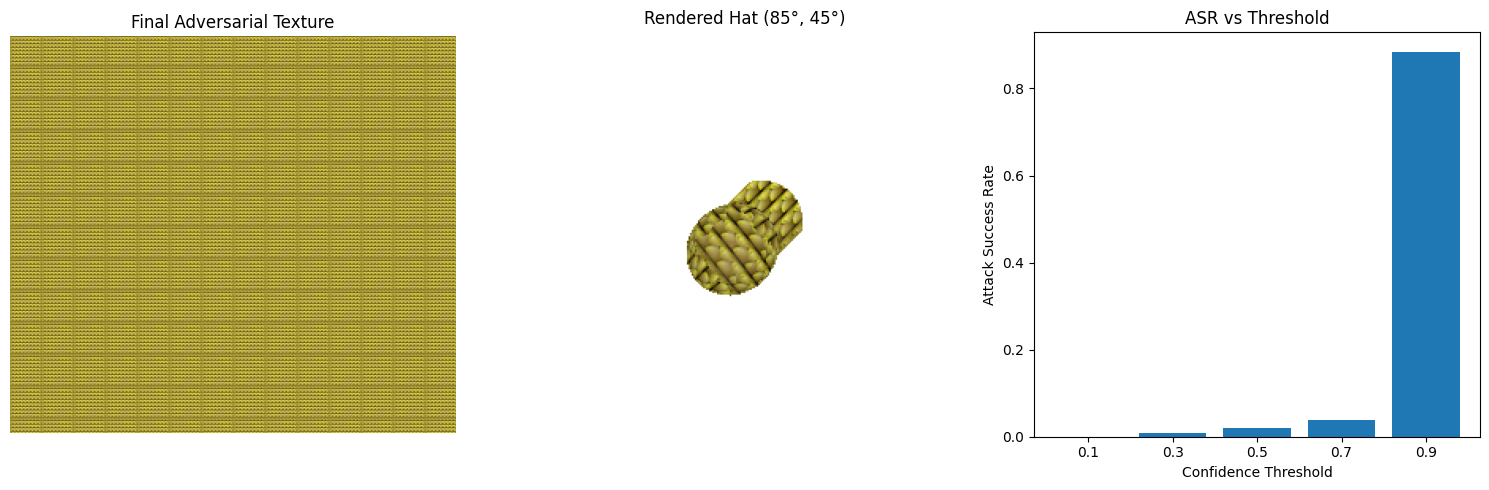

2026-02-15 23:19:33,493 | Training complete!
2026-02-15 23:19:33,494 | Final texture saved to: ./outputs/final_texture.png


In [17]:
def main():
    #Initialize models
    logger.info("Initializing models...")
    generator = FCNGenerator(latent_channels=CONFIG['latent_channels'], latent_size=CONFIG['latent_size']).to(device)
    aux_net = AuxiliaryNetwork(latent_channels=CONFIG['latent_channels']).to(device)
    logger.info(f"Generator params: {sum(p.numel() for p in generator.parameters()):}")
    logger.info(f"Auxiliary params: {sum(p.numel() for p in aux_net.parameters()):}")
    
    #Stage 1: Train generator
    logger.info("="*50)
    logger.info("STAGE 1: Generator Training")
    logger.info("="*50)
    generator = train_stage1(generator, aux_net, detector, dataset, CONFIG)
    
    #Stage 2: Optimize latent
    logger.info("="*50)
    logger.info("STAGE 2: Latent Optimization")
    logger.info("="*50)
    best_z_local, final_texture = train_stage2(generator, detector, dataset, CONFIG)
    
    #Evaluation
    logger.info("="*50)
    logger.info("EVALUATION")
    logger.info("="*50)
    asr_results = evaluate_texture(generator, detector, dataset, best_z_local, CONFIG)
    export_print_template(final_texture, CONFIG['mesh_path'], CONFIG, f"{CONFIG['output_dir']}/print_template.png")
    
    #Final visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    #Final texture
    axes[0].imshow(final_texture[0].permute(1, 2, 0).cpu())
    axes[0].set_title('Final Adversarial Texture')
    axes[0].axis('off')
    #Rendered examples
    with torch.no_grad():
        toroidal_viz = ToroidalLatent(
            local_size=CONFIG['local_latent_size'],
            crop_size=CONFIG['latent_size'],
            latent_channels=CONFIG['latent_channels'],
            device=device
        )
        toroidal_viz.z_local.data = best_z_local
        z_canon = toroidal_viz.get_canonical_crop()
        viz_texture = generator.generate(z_canon)
        rendered, alpha = renderer.render(viz_texture, 85, 45, 1.0)
    axes[1].imshow(rendered[0].permute(1, 2, 0).cpu())
    axes[1].set_title('Rendered Hat (85°, 45°)')
    axes[1].axis('off')
    
    #ASR plot
    thresholds = list(asr_results.keys())
    values = [asr_results[t] for t in thresholds]
    axes[2].bar(range(len(thresholds)), values)
    axes[2].set_xticks(range(len(thresholds)))
    axes[2].set_xticklabels([f'{t}' for t in thresholds])
    axes[2].set_xlabel('Confidence Threshold')
    axes[2].set_ylabel('Attack Success Rate')
    axes[2].set_title('ASR vs Threshold')
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_dir']}/final_results.png", dpi=150)
    plt.show()
    logger.info("Training complete!")
    logger.info(f"Final texture saved to: {CONFIG['output_dir']}/final_texture.png")
    return generator, best_z_local, final_texture

#Run if this is the main notebook
if __name__ == "__main__":
    generator, z_local, texture = main()

In [ ]:
checkpoint = torch.load('./outputs/stage2_final.pth', map_location=device)
z_local = checkpoint['z_local']
generator.load_state_dict(checkpoint['generator'])
toroidal_tmp = ToroidalLatent(local_size=CONFIG['local_latent_size'], crop_size=CONFIG['latent_size'], latent_channels=CONFIG['latent_channels'], device=device)
toroidal_tmp.z_local.data = z_local
z_canon = toroidal_tmp.get_canonical_crop()
with torch.no_grad():
    texture = generator.generate(z_canon)

logger.info("="*50)
logger.info("EVALUATION")
logger.info("="*50)
asr_results = evaluate_texture(generator, detector, dataset, z_local, CONFIG)
export_print_template(texture, CONFIG['mesh_path'], CONFIG, f"{CONFIG['output_dir']}/print_template.png")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(texture[0].permute(1, 2, 0).cpu())
axes[0].set_title('Final Adversarial Texture')
axes[0].axis('off')

with torch.no_grad():
    toroidal_viz = ToroidalLatent(
        local_size=CONFIG['local_latent_size'],
        crop_size=CONFIG['latent_size'],
        latent_channels=CONFIG['latent_channels'],
        device=device
    )
    toroidal_viz.z_local.data = z_local
    z_canon = toroidal_viz.get_canonical_crop()
    viz_texture = generator.generate(z_canon)
    rendered, alpha = renderer.render(viz_texture, 85, 45, 1.0)

axes[1].imshow(rendered[0].permute(1, 2, 0).cpu())
axes[1].set_title('Rendered Hat (85°, 45°)')
axes[1].axis('off')

thresholds = list(asr_results.keys())
values = [asr_results[t] for t in thresholds]
axes[2].bar(range(len(thresholds)), values)
axes[2].set_xticks(range(len(thresholds)))
axes[2].set_xticklabels([f'{t}' for t in thresholds])
axes[2].set_xlabel('Confidence Threshold')
axes[2].set_ylabel('Attack Success Rate')
axes[2].set_title('ASR vs Threshold')
plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/final_results.png", dpi=150)
plt.show()
logger.info("Training complete!")
logger.info(f"Final texture saved to: {CONFIG['output_dir']}/final_texture.png")

In [ ]:
with torch.no_grad():
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False)
    detected_crop, detected_full, total = 0, 0, 0
    for batch in dataloader:
        scene = batch['image'].to(device)
        results_full = detector.detect(scene, conf_threshold=0.5)
        crops = crop_to_person(scene, batch['person_bbox'].to(device), target_size=640, pad_ratio=0.5)
        results_crop = detector.detect(crops, conf_threshold=0.5)
        for name in results_full:
            for i in range(len(results_full[name])):
                total += 1
                if len(results_full[name][i]['boxes']) > 0: detected_full += 1
                if len(results_crop[name][i]['boxes']) > 0: detected_crop += 1
    print(f"Baseline detection rate - Full scene: {detected_full/total:.1%}, Crops: {detected_crop/total:.1%}")

In [ ]:
with torch.no_grad():
    toroidal = ToroidalLatent(local_size=CONFIG['local_latent_size'], crop_size=CONFIG['latent_size'], latent_channels=CONFIG['latent_channels'], device=device)
    toroidal.z_local.data = z_local
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False)
    attacked, baseline, total = 0, 0, 0
    for batch in dataloader:
        actual_batch = batch['image'].shape[0]
        z_canon = toroidal.get_canonical_crop().expand(actual_batch, -1, -1, -1)
        tex = generator.generate(z_canon)
        elevs = batch['elevation'].tolist()
        azims = batch['azimuth'].tolist()
        scls = batch['scale'].tolist()
        rendered_hat, alpha = renderer.render(tex,
            elevation=torch.tensor(elevs, dtype=torch.float32, device=device),
            azimuth=torch.tensor(azims, dtype=torch.float32, device=device),
            scale=torch.tensor(scls, dtype=torch.float32, device=device))
        scene = batch['image'].to(device)
        hat_mask = batch['hat_mask'].to(device)
        composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
        #Attacked crops
        crops_atk = crop_to_person(composite, batch['person_bbox'].to(device), target_size=640, pad_ratio=0.5)
        results_atk = detector.detect(crops_atk, conf_threshold=0.5)
        #Baseline crops (no attack)
        crops_clean = crop_to_person(scene, batch['person_bbox'].to(device), target_size=640, pad_ratio=0.5)
        results_clean = detector.detect(crops_clean, conf_threshold=0.5)
        for name in results_atk:
            for i in range(len(results_atk[name])):
                total += 1
                if len(results_atk[name][i]['boxes']) > 0: attacked += 1
                if len(results_clean[name][i]['boxes']) > 0: baseline += 1
    print(f"Crop baseline detection: {baseline/total:.1%}")
    print(f"Crop attacked detection: {attacked/total:.1%}")
    print(f"Relative suppression: {1 - attacked/max(baseline,1):.1%}")

# DEBUGGING

In [ ]:
#Find bugs
torch.autograd.set_detect_anomaly(True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)
batch = next(iter(dataloader))
generator.train()
z = torch.randn(2, CONFIG['latent_channels'], CONFIG['latent_size'], CONFIG['latent_size'], device=device)
texture = generator.generate(z)
rendered_hat, alpha = renderer.render(texture, elevation=torch.tensor([55.0, 60.0], dtype=torch.float32, device=device), azimuth=torch.tensor([5.0, 10.0], dtype=torch.float32, device=device), scale=torch.tensor([1.0, 1.0], dtype=torch.float32, device=device))
scene = batch['image'].to(device)
hat_mask = batch['hat_mask'].to(device)
composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
try:
    loss = detector.compute_loss(composite)
    loss.backward()
    print("SUCCESS no inplace issues")
except RuntimeError as e:
    print(f"FAILED: {e}")
torch.autograd.set_detect_anomaly(False)

In [ ]:
with torch.no_grad():
    batch = next(iter(torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)))
    z = torch.randn(4, CONFIG['latent_channels'], CONFIG['latent_size'], CONFIG['latent_size'], device=device)
    texture = generator.generate(z)
    rendered_hat, alpha = renderer.render(texture, elevation=batch['elevation'].to(device), azimuth=batch['azimuth'].to(device), scale=batch['scale'].to(device))
    scene = batch['image'].to(device)
    hat_mask = batch['hat_mask'].to(device)
    composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
    fig, axes = plt.subplots(4, 3, figsize=(12, 16))
    for i in range(4):
        axes[i][0].imshow(scene[i].permute(1,2,0).cpu())
        axes[i][0].set_title('Original')
        axes[i][1].imshow(hat_mask[i][0].cpu(), cmap='gray')
        axes[i][1].set_title('Hat Mask')
        axes[i][2].imshow(composite[i].permute(1,2,0).cpu())
        axes[i][2].set_title('Composite')
    for ax in axes.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
with torch.no_grad():
    batch = next(iter(torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)))
    scene = batch['image'].to(device)
    person_crops = crop_to_person(composite, batch['person_bbox'].to(device), target_size=CONFIG['detector_input_size'])
    baseline_loss = detector.compute_loss(person_crops)
    print(f"Baseline det loss (no attack): {baseline_loss.item():.4f}")

In [ ]:
with torch.no_grad():
    batch = next(iter(torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)))
    scene = batch['image'].to(device)
    person_crops = crop_to_person(composite, batch['person_bbox'].to(device), target_size=CONFIG['detector_input_size'])
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i in range(4):
        axes[i].imshow(person_crops[i].permute(1,2,0).cpu())
        axes[i].set_title(f'Crop {i}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
with torch.no_grad():
    batch = next(iter(torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)))
    z = torch.randn(4, CONFIG['latent_channels'], CONFIG['latent_size'], CONFIG['latent_size'], device=device)
    texture = generator.generate(z)
    rendered_hat, alpha = renderer.render(texture, elevation=batch['elevation'].to(device), azimuth=batch['azimuth'].to(device), scale=batch['scale'].to(device))
    scene = batch['image'].to(device)
    hat_mask = batch['hat_mask'].to(device)
    composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
    fig, axes = plt.subplots(4, 3, figsize=(12, 16))
    for i in range(4):
        axes[i][0].imshow(scene[i].permute(1,2,0).cpu())
        axes[i][0].set_title('Original')
        axes[i][1].imshow(hat_mask[i][0].cpu(), cmap='gray')
        axes[i][1].set_title('Hat Mask')
        axes[i][2].imshow(composite[i].permute(1,2,0).cpu())
        axes[i][2].set_title('Composite')
    for ax in axes.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
with torch.no_grad():
    batch = next(iter(torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)))
    hat_mask = batch['hat_mask']
    person_bbox = batch['person_bbox']
    for i in range(4):
        ys, xs = torch.where(hat_mask[i, 0] > 0.5)
        if len(ys) > 0:
            h = (ys.max() - ys.min()).item()
            w = (xs.max() - xs.min()).item()
            # What it becomes in person crop
            x1, y1, x2, y2 = person_bbox[i]
            bw, bh = x2 - x1, y2 - y1
            side = max(bw, bh) * 1.5
            scale = 640 / side
            print(f"Frame {i}: hat {w}x{h}px in 1920 scene, ~{int(w*scale)}x{int(h*scale)}px in 640 crop")

In [ ]:
with torch.no_grad():
    batch = next(iter(torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)))
    generator.eval()
    z = torch.randn(4, CONFIG['latent_channels'], CONFIG['latent_size'], CONFIG['latent_size'], device=device)
    texture = generator.generate(z)
    elevs = batch['elevation'].tolist()
    azims = batch['azimuth'].tolist()
    scls = batch['scale'].tolist()
    rendered_hat, alpha = renderer.render(texture,
        elevation=torch.tensor(elevs, dtype=torch.float32, device=device),
        azimuth=torch.tensor(azims, dtype=torch.float32, device=device),
        scale=torch.tensor(scls, dtype=torch.float32, device=device))
    scene = batch['image'].to(device)
    hat_mask = batch['hat_mask'].to(device)
    composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
    person_crops = crop_to_person(composite, batch['person_bbox'].to(device), target_size=640)
    hat_mask_crops = crop_hat_mask(hat_mask, batch['person_bbox'].to(device), target_size=640)
    print("=== HAT MASK IN CROPS ===")
    for i in range(4):
        nonzero = (hat_mask_crops[i] > 0.1).float().sum().item()
        total = 640 * 640
        print(f"  Frame {i}: hat covers {nonzero:.0f}/{total} pixels ({100*nonzero/total:.1f}%)")
    w8 = F.adaptive_avg_pool2d(hat_mask_crops, (80, 80)).flatten(2)
    w16 = F.adaptive_avg_pool2d(hat_mask_crops, (40, 40)).flatten(2)
    w32 = F.adaptive_avg_pool2d(hat_mask_crops, (20, 20)).flatten(2)
    anchor_weights = torch.cat([w8, w16, w32], dim=2).squeeze(1)
    hat_sum = anchor_weights.sum(dim=1, keepdim=True) + 1e-8
    n_anchors = anchor_weights.shape[1]
    anchor_weights_norm = 0.8 * (anchor_weights / hat_sum) + 0.2 / n_anchors
    print("\n=== ANCHOR WEIGHTS ===")
    for i in range(4):
        aw = anchor_weights_norm[i]
        hat_anchors = (anchor_weights[i] > 0.01).sum().item()
        print(f"  Frame {i}: {hat_anchors}/{n_anchors} hat anchors, max_w={aw.max():.4f}, min_w={aw.min():.6f}, sum_hat_w={aw[anchor_weights[i]>0.01].sum():.3f}")
    model = list(detector.models.values())[0]
    preds = model.model(person_crops)
    if isinstance(preds, (list, tuple)):
        preds = preds[0]
    if preds.shape[1] == 84:
        person_conf = preds[:, 4, :]
    
    print("\n=== RAW DETECTOR CONFIDENCES ===")
    for i in range(4):
        confs = person_conf[i]
        print(f"  Frame {i}: max={confs.max():.4f}, top10_mean={confs.topk(10)[0].mean():.4f}, top100_mean={confs.topk(100)[0].mean():.4f}")
        
        #Which anchors are hot?
        top10_idx = confs.topk(10)[1]
        hat_aw = anchor_weights[i]
        top10_hat_overlap = hat_aw[top10_idx].mean().item()
        print(f"           top10 anchors hat overlap: {top10_hat_overlap:.4f}")
    
    print("\n=== LOSS COMPARISON ===")
    for i in range(4):
        confs = person_conf[i]
        unweighted = confs.topk(10)[0].mean().item()
        weighted = (confs * anchor_weights_norm[i]).sum().item()
        print(f"  Frame {i}: unweighted_top10={unweighted:.4f}, weighted={weighted:.6f}")
    
    fig, axes = plt.subplots(4, 3, figsize=(12, 16))
    for i in range(4):
        axes[i][0].imshow(person_crops[i].permute(1,2,0).cpu())
        axes[i][0].set_title(f'Person Crop {i}')
        axes[i][1].imshow(hat_mask_crops[i, 0].cpu(), cmap='hot')
        axes[i][1].set_title(f'Hat Mask in Crop ({(hat_mask_crops[i]>0.1).float().sum():.0f}px)')
        # Overlay
        overlay = person_crops[i].permute(1,2,0).cpu().clone()
        mask_binary = (hat_mask_crops[i, 0] > 0.1).cpu().float()
        overlay[:,:,0] = overlay[:,:,0] * 0.5 + mask_binary * 0.5
        axes[i][2].imshow(overlay)
        axes[i][2].set_title('Overlay')
    for ax in axes.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
generator.train()
batch = next(iter(torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)))
z = torch.randn(8, CONFIG['latent_channels'], CONFIG['latent_size'], CONFIG['latent_size'], device=device)
texture = generator.generate(z)

rendered_hat, alpha = renderer.render(texture,
    elevation=torch.tensor(batch['elevation'].tolist(), dtype=torch.float32, device=device),
    azimuth=torch.tensor(batch['azimuth'].tolist(), dtype=torch.float32, device=device),
    scale=torch.tensor(batch['scale'].tolist(), dtype=torch.float32, device=device))

scene = batch['image'].to(device)
hat_mask = batch['hat_mask'].to(device)

# Clean composite — NO augmentations
composite = composite_hat_on_scene(scene, hat_mask, rendered_hat, alpha)
person_crops = crop_to_person(composite, batch['person_bbox'].to(device), target_size=640)

# Unweighted top-10 loss
model = list(detector.models.values())[0]
preds = model.model(person_crops)
if isinstance(preds, (list, tuple)):
    preds = preds[0]
person_conf = preds[:, 4, :]
loss = person_conf.topk(10, dim=1)[0].mean()

# Get gradients at each stage
texture_grad = torch.autograd.grad(loss, texture, retain_graph=True)[0]
rh_grad = torch.autograd.grad(loss, rendered_hat, retain_graph=True)[0]

print("=== TEXTURE GRADIENT (what the generator sees) ===")
print(f"  norm={texture_grad.norm():.8f}, max_abs={texture_grad.abs().max():.8f}, mean_abs={texture_grad.abs().mean():.8f}")

print(f"\n=== RENDERED HAT GRADIENT ===")
print(f"  norm={rh_grad.norm():.8f}, max_abs={rh_grad.abs().max():.8f}")

# Now compare: same loss but WITH all augmentations (run 5 times to see variance)
print(f"\n=== GRADIENT VARIANCE FROM AUGMENTATIONS ===")
grads = []
for trial in range(5):
    opt_tmp = torch.optim.Adam(generator.parameters(), lr=1e-4)
    opt_tmp.zero_grad()
    z2 = torch.randn(8, CONFIG['latent_channels'], CONFIG['latent_size'], CONFIG['latent_size'], device=device)
    tex2 = generator.generate(z2)
    rh2, al2 = renderer.render(tex2,
        elevation=torch.tensor(batch['elevation'].tolist(), dtype=torch.float32, device=device),
        azimuth=torch.tensor(batch['azimuth'].tolist(), dtype=torch.float32, device=device),
        scale=torch.tensor(batch['scale'].tolist(), dtype=torch.float32, device=device))
    rh2 = patch_cutout(rh2, al2, CONFIG['cutout_prob'], CONFIG['cutout_ratio'])
    rh2 = add_light_spots(rh2, al2)
    rh2 = add_shadows(rh2, al2)
    rh2 = simulate_printing(rh2)
    comp2 = composite_hat_on_scene(scene, hat_mask, rh2, al2)
    crops2 = crop_to_person(comp2, batch['person_bbox'].to(device), target_size=640)
    crops2 = constrained_augmentation(crops2)
    crops2 = apply_environmental_augmentation(crops2)
    crops2 = shakedrop_forward(crops2, drop_prob=CONFIG['shakedrop_prob'])
    preds2 = model.model(crops2)
    if isinstance(preds2, (list, tuple)):
        preds2 = preds2[0]
    loss2 = preds2[:, 4, :].topk(10, dim=1)[0].mean()
    loss2.backward()
    # Collect first conv layer gradient as proxy
    first_conv = list(generator.parameters())[0]
    grads.append(first_conv.grad.clone().flatten())
    
grads = torch.stack(grads)
signal = grads.mean(dim=0).norm().item()
noise = grads.std(dim=0).norm().item()
print(f"  Gradient signal (mean across trials): {signal:.8f}")
print(f"  Gradient noise (std across trials):   {noise:.8f}")
print(f"  SNR (signal/noise): {signal/(noise+1e-12):.4f}")

# Anchor analysis at different k
print(f"\n=== ANCHOR-HAT OVERLAP AT DIFFERENT K ===")
hat_mask_crops = crop_hat_mask(hat_mask, batch['person_bbox'].to(device), target_size=640)
w8 = F.adaptive_avg_pool2d(hat_mask_crops, (80, 80)).flatten(2)
w16 = F.adaptive_avg_pool2d(hat_mask_crops, (40, 40)).flatten(2)
w32 = F.adaptive_avg_pool2d(hat_mask_crops, (20, 20)).flatten(2)
hat_at_anchors = torch.cat([w8, w16, w32], dim=2).squeeze(1)

for i in range(min(4, person_conf.shape[0])):
    confs = person_conf[i].detach()
    for k in [10, 50, 100, 500, 1000]:
        topk_idx = confs.topk(k)[1]
        overlap = hat_at_anchors[i][topk_idx].sum().item()
        mean_conf = confs.topk(k)[0].mean().item()
        print(f"  Frame {i}, top-{k}: mean_conf={mean_conf:.4f}, hat_overlap={overlap:.4f}")